10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0
10.0
-10.0
-10.0
10.0

M:  (11, 11) 
 [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.13333333 0.03333333 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.03333333 0.13333333 0.03333333 0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.03333333 0.13333333 0.03333333 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.03333333 0.13333333 0.03333333
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.03333333 0.13333333
  0.03333333 0.         0.         0.         0.        ]
 [0.         0.         0.         0.   

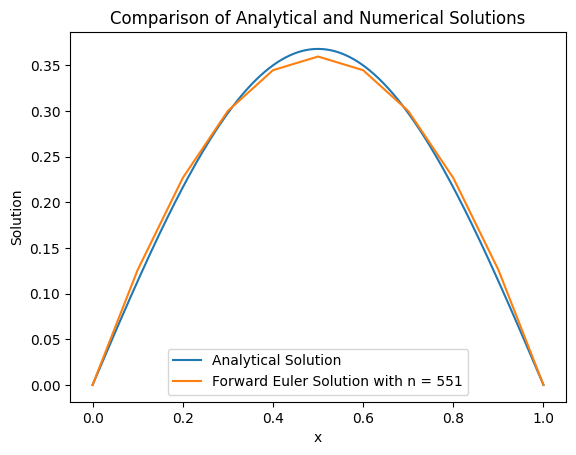

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Jakob Long, JRL4725

# returns the original function
def f(x, t):
    return ((np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x))

# returns the analytical solution
def u_analytical(x, t):
    return (np.exp(-t) * np.sin(np.pi * x))

# spatial conditions, at t = 1
def u_boundary(x):
    return np.sin(np.pi * x)

# initalizes our stiffness, mass & force matrices
def initialize_matrices(N,n):
    Mg = np.zeros((N, N))
    Kg = np.zeros((N, N))
    Fg = np.zeros((N, n + 1))
    return Mg, Kg, Fg

# function to convert from local nodal mapping to global
def construct_local_to_global_map(N):
    return np.vstack((np.linspace(0, N - 2, N - 1), np.linspace(1, N - 1, N - 1))).T

# Creates our basis functions, based on quadrature
def generate_local_basis_functions(h):
    phi_1 = lambda eta: (1 - eta) / 2
    phi_2 = lambda eta: (1 + eta) / 2

    dphi = np.array([-1 / 2, 1 / 2])
    deta_dx = 2 / h
    dx_deta = h / 2

    eta_quad_1 = -1 / np.sqrt(3)
    eta_quad_2 = 1 / np.sqrt(3)

    phi_eta = np.array([[phi_1(eta_quad_1), phi_1(eta_quad_2)],
                        [phi_2(eta_quad_1), phi_2(eta_quad_2)]])
    
    return phi_eta, dphi, deta_dx, dx_deta

# Constructs matrices for stiffness, mass & force
def calculate_matrices(N,ts,Kg,Mg,Fg, local2global_map, phi_eta, dphi, deta_dx, dx_deta,h):
    for k in range(N - 1):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))

        for l in range(2):
            for m in range(2):
                mlocal[l, m] = (phi_eta[l, 0] * phi_eta[m, 0] + phi_eta[l, 1] * phi_eta[m, 1] ) * h/2
                klocal[l, m] = dphi[l] * deta_dx * dphi[m] * deta_dx * dx_deta * 2

        for l in range(2):
            global_node = int(local2global_map[k, l])
            global_node = max(0, min(N - 1, global_node))
            for m in range(2):
                global_node2 = int(local2global_map[k, m])
                global_node2 = max(0, min(N - 1, global_node2))
                print(klocal[l, m])
                Kg[global_node, global_node2] += klocal[l, m]
                Mg[global_node, global_node2] += mlocal[l, m]
        
        Fg[k, :] = -(f((-1/np.sqrt(3)), ts) * phi_eta[0,0] + f((1/np.sqrt(3)), ts) * phi_eta[0,1]) * (1/8)
        
    return Mg, Kg, Fg

# Applies & constructs boundary conditions of u(0,t) = u(1,t) = 0
def apply_boundary_conditions(Mg, N):
    Mg[0, :] = 0
    Mg[:, 0] = 0
    Mg[N - 1, :] = 0
    Mg[:, N - 1] = 0
    Mg[0, 0] = 1
    Mg[N - 1, N - 1] = 1
    
    bounds = [0,0]
    dirichlet_bc = np.eye(N)
    dirichlet_bc[0,0] = bounds[0]
    dirichlet_bc[N-1,N-1] = bounds[1]
    return Mg, dirichlet_bc

# Solves matrix operations necessary to perform Euler approximations
def matrix_operations(Mg,Kg,dt):
    invM = np.linalg.inv(Mg)
    MK = np.dot(invM, Kg)
    B = (1/dt) * Mg + Kg
    invB = np.linalg.inv(B)
    
    return invM, MK, invB

# Performs Forward or Backward euler approximation
def solve_equation(N, n, dt, MK, invM,Mg, Fg, dbc, method,xi,invB):
    u = np.zeros((N, n + 1))
    u[:, 0] = u_boundary(xi)

    if method == 'FE':
        for t in range(n):
            u[:, t + 1] = u[:, t] - dt * MK.dot(u[:, t]) + dt * invM.dot(Fg[:, t])
            u[:, t + 1] = dbc.dot(u[:, t + 1])
    else:
        for t in range(n):
            u[:, t + 1] = (1 / dt) * invB.dot(Mg.dot(u[:, t])) + invB.dot(Fg[:, t])
            u[:, t + 1] = dbc.dot(u[:, t + 1])

    return u

# Plots our approximation against analytical solution
def plot_solutions(xn, sol, x, u, n,method):
    plt.plot(xn, sol, label='Analytical Solution')
    if method == 'FE':
        plt.plot(x, u[:, n], label=f'Forward Euler Solution with n = {n}')
    else:
        plt.plot(x, u[:, n], label=f'Backward Euler Solution with n = {n}')
    plt.xlabel('x')
    plt.ylabel('Solution')
    plt.title('Comparison of Analytical and Numerical Solutions')
    plt.legend()
    plt.show()

def main():
    N = int(input("Enter the number of Nodes: "))
    n = int(input("Enter the number of time steps: "))
    xi = np.linspace(0,1,N)
    h = xi[1] - xi[0]
    dt = 1/n
    ts = np.linspace(0,1,n+1)
    
    while True:
        method = str(input("Please type FE for Forward Euler or Please type BE for Backward Euler: ").upper())
        # Performs & plots forward Euler approximation
        if method == 'FE':
            Mg, Kg, Fg = initialize_matrices(N,n)
            local2global_map = construct_local_to_global_map(N)
            phi_eta, dphi, deta_dx, dx_deta = generate_local_basis_functions(h)
            Mg, Kg, Fg = calculate_matrices(N, ts, Kg, Mg, Fg, local2global_map, phi_eta, dphi, deta_dx, dx_deta,h)
            Mg,dbc = apply_boundary_conditions(Mg, N)
            invM, MK, invB = matrix_operations(Mg,Kg,dt)
            u = solve_equation(N, n, dt, MK, invM, Mg, Fg, dbc, method,xi,invB)
            print('\nM: ',Mg.shape,'\n',Mg)
            print('\nK: ',Kg.shape,'\n',Kg)
            print('\nF: ',Fg.shape,'\n',Fg)
            print('\nU: ',u.shape,'\n',u)
            x = np.linspace(0, 1, N)
            xn = np.linspace(0, 1, 1000)
            sol = u_analytical(xn,1)
            plot_solutions(xn, sol, x, u, n, method)
            break
        # Performs & plots Backward Euler approximation
        elif method == 'BE':
            Mg, Kg, Fg = initialize_matrices(N,n)
            local2global_map = construct_local_to_global_map(N)
            phi_eta, dphi, deta_dx, dx_deta = generate_local_basis_functions(h)
            Mg, Kg, Fg = calculate_matrices(N, ts, Kg, Mg, Fg, local2global_map, phi_eta, dphi, deta_dx, dx_deta,h)
            Mg,dbc = apply_boundary_conditions(Mg, N)
            invM, MK, invB = matrix_operations(Mg,Kg,dt)
            u = solve_equation(N, n, dt, MK, invM, Mg, Fg, dbc, method,xi,invB)
            print('\nM: ',Mg.shape,'\n',Mg)
            print('\nK: ',Kg.shape,'\n',Kg)
            print('\nF: ',Fg.shape,'\n',Fg)
            print('\nU: ',u.shape,'\n',u)
            x = np.linspace(0, 1, N)
            xn = np.linspace(0, 1, 1000)
            sol = u_analytical(xn,1)
            plot_solutions(xn, sol, x, u, n, method)
            break
        else:
            print("Please select FE or BE.")
    
if __name__ == "__main__":
    main()